### Cell 1 - Imports

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

### Cell 2 - Processing the file

In [2]:
DATASET_PATH = "Data/genres_original"
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
file_paths = []
y = []

data = pd.read_csv("Data/features_3_sec.csv")
X = data.drop(columns=["label", "filename"])
y = data["label"]

#Normalising the data
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [3]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
x_test_pca = pca.fit_transform(x_test)
x_train_pca = pca.fit_transform(x_train)
x_test_combined = np.concatenate((x_test, x_test_pca), axis=1)
x_train_combined = np.concatenate((x_train, x_train_pca), axis=1)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

# Calculate the center of each cluster by averaging the principal components
centroids = finalDf.groupby('label')[['principal component 1', 'principal component 2']].mean()

In [4]:
for i in range(x_test_pca.shape[1]):  # Loop through each of the 3 components
    pc_min = np.min(x_test_pca[:, i])
    pc_max = np.max(x_test_pca[:, i])
    print(f"PC{i+1} range: [{pc_min:.4f}, {pc_max:.4f}]")

PC1 range: [-0.9020, 1.3625]
PC2 range: [-0.8545, 0.8303]


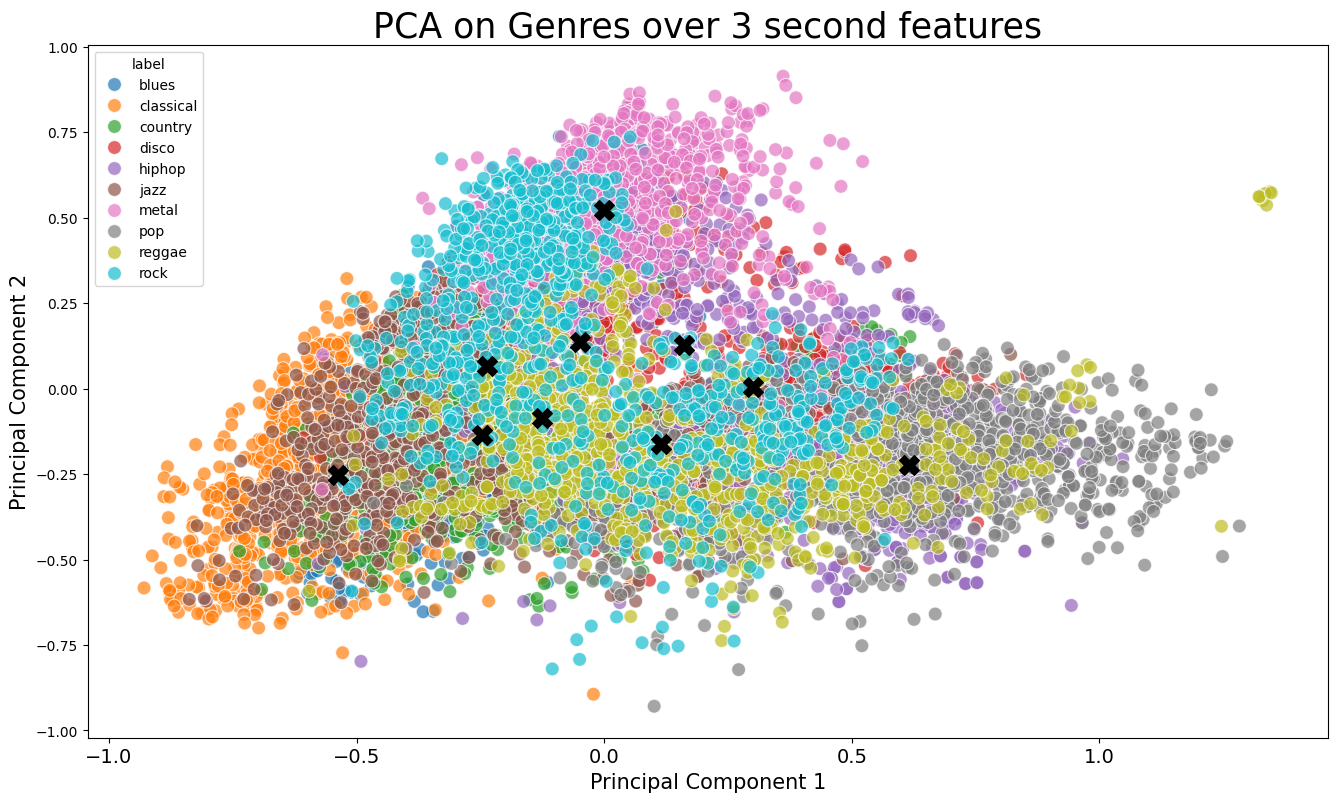

In [5]:
plt.figure(figsize=(16, 9))
sns.scatterplot(x="principal component 1", y="principal component 2", data=finalDf, hue="label", alpha=0.7, s=100)

# Plot the centroids
for label, row in centroids.iterrows():
    plt.scatter(row['principal component 1'], row['principal component 2'], 
                label=f'Centroid {label}', s=200, marker='X', edgecolor='black', c='black')

plt.title('PCA on Genres over 3 second features', fontsize=25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Principal Component 1", fontsize=15)
plt.ylabel("Principal Component 2", fontsize=15)
#plt.savefig("Appendix\Images\PCA_3_seconds.jpg")
plt.show()


### Cell 3 - Feature extraction

### Cell 5 - Train test split

In [6]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=len(genres))
y_test_encoded = to_categorical(y_test, num_classes=len(genres))

# Check the shapes of the train and test sets
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
print(f"Shape of y_test_encoded: {y_test_encoded.shape}")


Shape of x_train: (7992, 58)
Shape of x_test: (1998, 58)
Shape of y_train: (7992,)
Shape of y_test: (1998,)
Shape of y_train_encoded: (7992, 10)
Shape of y_test_encoded: (1998, 10)


In [7]:
x_train_flattened = x_train_pca.flatten()
x_test_flattened = x_test_pca.flatten()
x_train_pca.shape


(7992, 2)

### Cell 7 - Training SVM model

In [8]:
# Train the SVM model
svm_model = SVC(probability=True)
svm_model.fit(x_train_pca, y_train)

# Predict on the test set
y_pred = svm_model.predict(x_test_pca)


### Cell 8 - Defining CNN

In [ ]:
# Define the CNN model architecture
cnn_model = Sequential([
    # First convolutional layer with 'same' padding
    layers.Conv1D(64, 3, activation='relu', padding='same', input_shape = (x_test_pca.shape[1],1)),
    layers.MaxPooling1D(2, padding='same'),  # MaxPooling2D with same padding

    # Second convolutional layer with 'same' padding
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2, padding='same'),

    # Third convolutional layer with 'same' padding
    layers.Conv1D(256, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2, padding='same'),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    # Output layer with softmax activation
    layers.Dense(len(genres), activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model architecture
cnn_model.summary()


c:\Users\ojlon\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,234 (1016.54 KB)

 Trainable params: 260,234 (1016.54 KB)

 Non-trainable params: 0 (0.00 B)

### Cell 9 - Training CNN model

In [10]:
# Train the CNN model
cnn_model.fit(x_train_pca, y_train_encoded, validation_data=(x_test_pca, y_test_encoded), epochs=5, batch_size=32)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2671 - loss: 1.9725 - val_accuracy: 0.2077 - val_loss: 2.3893
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3435 - loss: 1.6642 - val_accuracy: 0.1792 - val_loss: 2.6990
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3694 - loss: 1.6189 - val_accuracy: 0.1672 - val_loss: 2.8386
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3924 - loss: 1.5738 - val_accuracy: 0.2082 - val_loss: 2.7709
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3982 - loss: 1.5621 - val_accuracy: 0.2167 - val_loss: 2.8042


### Creating a DNN

In [ ]:
# Define the Dense Neural Network (MLP) architecture
mlp_model = Sequential([
    layers.Input(shape=(x_test_pca.shape[1],)),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(len(label_encoder.classes_), activation='softmax')
])


# Compile the model
mlp_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,506 (697.29 KB)

 Trainable params: 176,586 (689.79 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
# Train the CNN model
mlp_model.fit(x_train_pca, y_train_encoded, validation_data=(x_test_pca, y_test_encoded), epochs=5, batch_size=32)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2769 - loss: 2.0760 - val_accuracy: 0.0986 - val_loss: 2.4280
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3426 - loss: 1.7115 - val_accuracy: 0.1481 - val_loss: 2.3184
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3514 - loss: 1.6702 - val_accuracy: 0.2057 - val_loss: 2.5268
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3666 - loss: 1.6436 - val_accuracy: 0.1767 - val_loss: 2.6811
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3559 - loss: 1.6604 - val_accuracy: 0.2137 - val_loss: 2.5880


### Cell 10 - XGBoost model 

In [13]:

xgb_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb_model.fit(x_train_pca, y_train)
y_pred_xgb = xgb_model.predict(x_test_pca)

### Cell 11 - Evaluate models

In [14]:
# Predict using the CNN model
y_pred_cnn = cnn_model.predict(x_test_pca)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

y_pred_dnn = mlp_model.predict(x_test_pca)
y_pred_dnn = np.argmax(y_pred_dnn, axis=1)

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy (CNN): {accuracy_cnn:.3f}")

accuracy_dnn = accuracy_score(y_test, y_pred_dnn)
print(f"Accuracy (DNN): {accuracy_dnn:.3f}")

accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy (SVM): {accuracy_svm:.3f}")

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy (XGBoost): {xgb_accuracy:.3f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy (CNN): 0.217
Accuracy (DNN): 0.214
Accuracy (SVM): 0.215
Accuracy (XGBoost): 0.178


### Cell 12 Creating an ensemble

In [15]:
# # Get predictions from each model
# xgb_preds_proba = xgb_model.predict_proba(x_test_combined)
# svm_preds_proba = svm_model.predict_proba(x_test_combined)
# cnn_preds_proba = cnn_model.predict(x_test_combined)

# # Average the predictions (soft voting)
# avg_preds_proba = (xgb_preds_proba + svm_preds_proba + cnn_preds_proba) / 3

# # Convert probabilities to class predictions
# ensemble_preds = np.argmax(avg_preds_proba, axis=1)

# # Evaluate the ensemble performance
# ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
# print(f"Ensemble Accuracy: {ensemble_accuracy:.3f}")


### Creating a confusion matrix for the ensemble

In [16]:
# # Get predictions from each model (XGBoost, SVM, CNN)
# xgb_preds = xgb_model.predict(x_test_combined)
# svm_preds = svm_model.predict(x_test_combined)
# cnn_preds = np.argmax(mlp_model.predict(x_test_combined), axis=1)

# # Soft Voting: average the predicted probabilities
# xgb_probs = xgb_model.predict_proba(x_test_combined)
# svm_probs = svm_model.predict_proba(x_test_combined)
# cnn_probs = mlp_model.predict(x_test_combined)

# # Average the probabilities (soft voting)
# ensemble_probs = (xgb_probs + svm_probs + cnn_probs) / 3
# ensemble_preds = np.argmax(ensemble_probs, axis=1)
# ensemble_cm = confusion_matrix(y_test, ensemble_preds)

# # Plot the confusion matrix for the ensemble model
# plt.figure(figsize=(8, 6))
# sns.heatmap(ensemble_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
# plt.title("Ensemble Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()

### Creating a confusion matrix for SVC

In [17]:
svm_preds = svm_model.predict(x_test_combined)
svm_cm = confusion_matrix(y_test, svm_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("SVM Confusion Matrix on PCA analysis")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


ValueError: X has 60 features, but SVC is expecting 2 features as input.

### Creating a confusion matrix for CNN

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


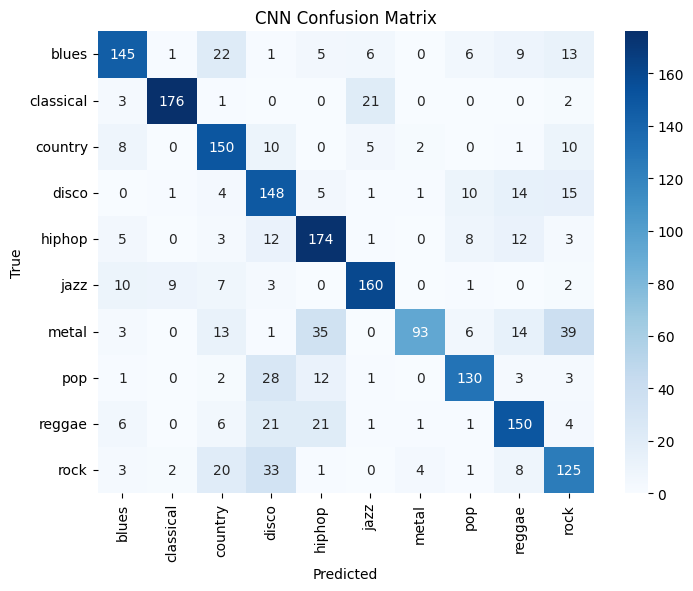

In [ ]:
cnn_preds = np.argmax(cnn_model.predict(x_test_combined), axis=1)
cnn_cm = confusion_matrix(y_test, cnn_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Creating a confusion matrix for XGB

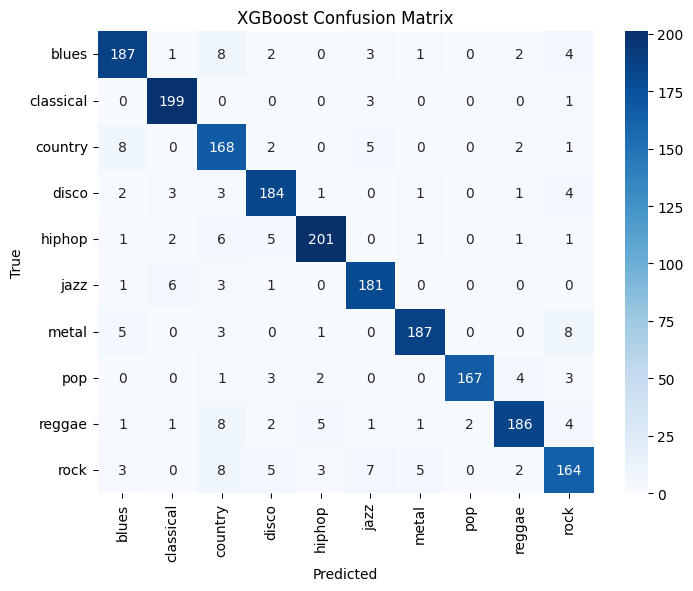

In [ ]:
xgb_preds = xgb_model.predict(x_test_combined)
xgb_cm = confusion_matrix(y_test, xgb_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
